In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from tqdm.notebook import tqdm

## One dimensional case

In [7]:
def bachelier_formula(S0, sigma, T, K):
    dn = (S0 - K) / (sigma * np.sqrt(T))
    return (S0 - K) * stats.norm.cdf(dn) + sigma * np.sqrt(T) * stats.norm.pdf(dn)

In [17]:
S0 = 3
T_values = np.linspace(1, 10, 100)
Ks = np.linspace(-5, 5, 100)
sigma = 1

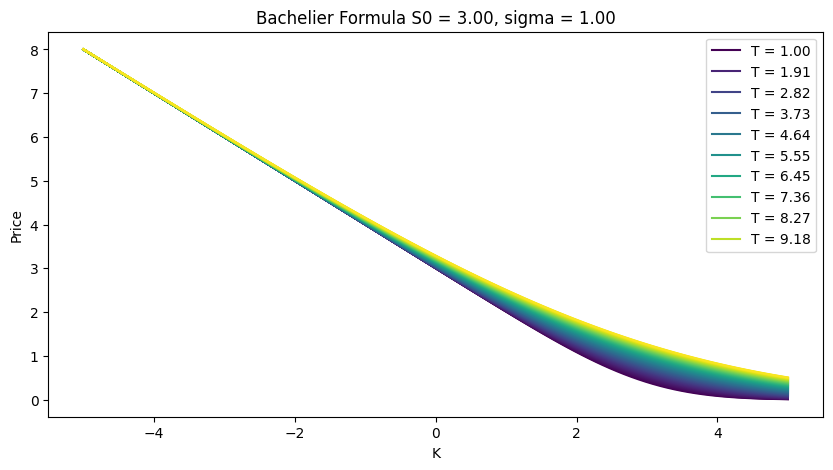

In [20]:
plt.figure(figsize=(10, 5))
colomap = plt.cm.viridis

for k, T in enumerate(T_values):
    prices = bachelier_formula(S0, sigma, T, Ks)
    if k % 10 == 0:
        plt.plot(Ks, prices, label='T = %.2f' % T, color=colomap(k / len(T_values)))
    else:
        plt.plot(Ks, prices, color=colomap(k / len(T_values)))

plt.xlabel('K')
plt.ylabel('Price')
plt.legend()
plt.title('Bachelier Formula S0 = %.2f, sigma = %.2f' % (S0, sigma))
plt.show()

In [30]:
def generate_process_1d(S0, sigma, T, n_precision, n_paths):
    dt = T / n_precision
    dW = np.random.normal(0, np.sqrt(dt), (n_paths, n_precision))
    W = np.cumsum(dW, axis=1)
    t = np.linspace(0, T, n_precision)
    S = S0 + sigma * W
    return t, S

(1000,) (10, 1000)


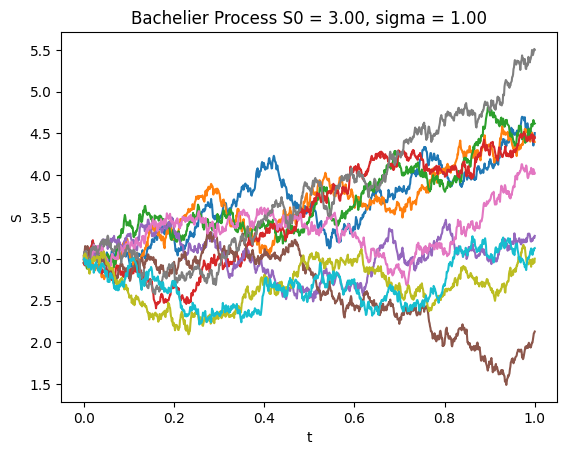

In [34]:
t, S = generate_process_1d(S0, sigma, 1, 1000, 10)
print(t.shape, S.shape)
plt.plot(t, S.T)
plt.xlabel('t')
plt.ylabel('S')
plt.title('Bachelier Process S0 = %.2f, sigma = %.2f' % (S0, sigma))
plt.show()

In [44]:
def monte_carlo_bachelier(S0, sigma, T, Ks, n_precision, n_paths):
    t, S = generate_process_1d(S0, sigma, T, n_precision, n_paths)
    payoff = np.maximum(S[:, -1, np.newaxis] - Ks[np.newaxis, :], 0)
    return np.mean(payoff, axis=0)

  0%|          | 0/100 [00:00<?, ?it/s]

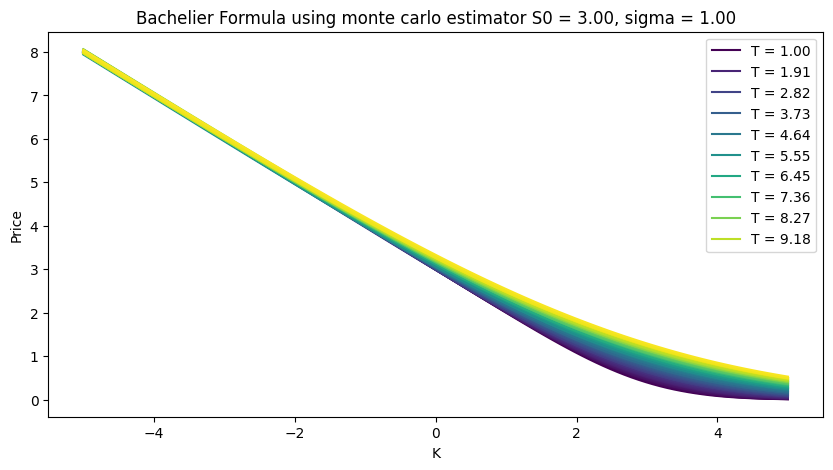

In [48]:
plt.figure(figsize=(10, 5))
colomap = plt.cm.viridis

for k, T in enumerate(tqdm(T_values)):
    prices = monte_carlo_bachelier(S0, sigma, T, Ks, 1000, 10000)
    if k % 10 == 0:
        plt.plot(Ks, prices, label='T = %.2f' % T, color=colomap(k / len(T_values)))
    else:
        plt.plot(Ks, prices, color=colomap(k / len(T_values)))

plt.xlabel('K')
plt.ylabel('Price')
plt.legend()
plt.title('Bachelier Formula using monte carlo estimator S0 = %.2f, sigma = %.2f' % (S0, sigma))
plt.show()

## Multidimensional case

In [49]:
def compute_std(sigmas, correlation_matrix):
    sum_1 = np.sum(sigmas ** 2)
    sum_2 = 0
    for i in range(len(sigmas)):
        for j in range(len(sigmas)):
            sum_2 += sigmas[i] * sigmas[j] * correlation_matrix[i, j]
    return np.sqrt(sum_1 + sum_2) / len(sigmas)

In [50]:
def basket_formula(S0s, sigmas, correlation_matrix, T, K):
    sigma = compute_std(sigmas, correlation_matrix)
    S0 = np.mean(S0s)
    return bachelier_formula(S0, sigma, T, K)

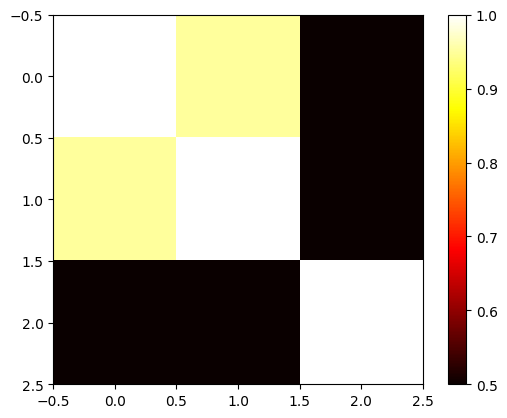

In [96]:
d = 3
S0s = np.random.uniform(-5, 5, d)
T_values = np.linspace(1, 10, 100)
Ks = np.linspace(-5, 5, 100)

sigmas = np.random.normal(1, 0.5, d)

# eigenvalues = np.random.uniform(0, 1, d)
# eigenvalues = eigenvalues / np.sum(eigenvalues) * d
# correlation_matrix = stats.random_correlation.rvs(eigenvalues)

correlation_matrix = np.array([[1, 0.9, 0], [0.9, 1, 0], [0, 0, 1]])

cholesky = np.linalg.cholesky(correlation_matrix)
plt.imshow((correlation_matrix + 1) / 2, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()           

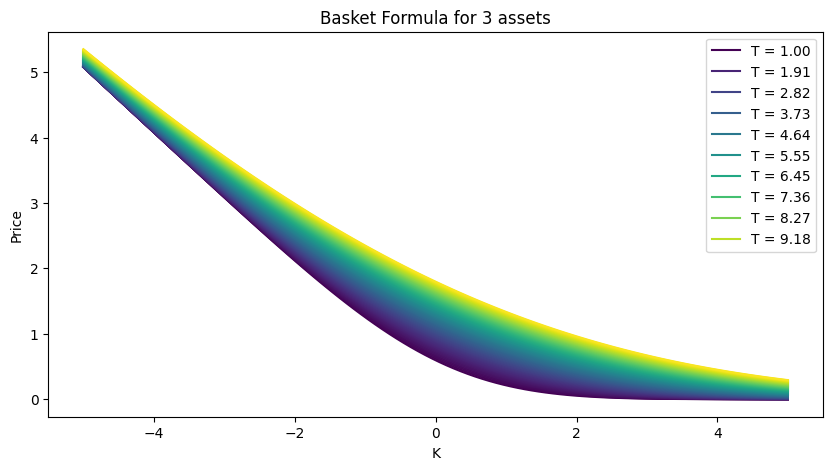

In [97]:
plt.figure(figsize=(10, 5))
colomap = plt.cm.viridis

for k, T in enumerate(T_values):
    prices = basket_formula(S0s, sigmas, correlation_matrix, T, Ks)
    if k % 10 == 0:
        plt.plot(Ks, prices, label='T = %.2f' % T, color=colomap(k / len(T_values)))
    else:
        plt.plot(Ks, prices, color=colomap(k / len(T_values)))

plt.xlabel('K')
plt.ylabel('Price')
plt.legend()
plt.title('Basket Formula for %d assets' % d)
plt.show()

In [98]:
def generate_process_nd(S0s, sigmas, cholesky_decomp, T, n_precision, n_paths):
    dt = T / n_precision
    dW = np.random.normal(0, np.sqrt(dt), (n_paths, n_precision, len(S0s)))
    dW = np.einsum('ijk,kl->ijl', dW, cholesky_decomp)
    W = np.cumsum(dW, axis=1)
    t = np.linspace(0, T, n_precision)
    S = S0s + sigmas[np.newaxis, np.newaxis, :] * W
    return t, S

(1000,) (1, 1000, 3)


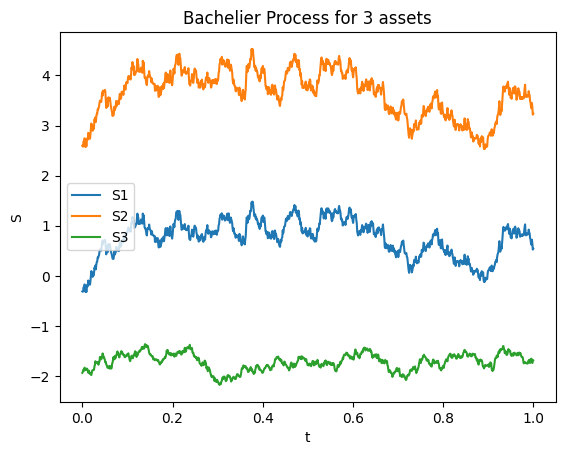

In [99]:
t, S = generate_process_nd(S0s, sigmas, correlation_matrix, 1, 1000, 1)
print(t.shape, S.shape)
for i in range(d):
    plt.plot(t, S[:, :, i].T, label='S%d' % (i+1))
plt.xlabel('t')
plt.ylabel('S')
plt.title('Bachelier Process for %d assets' % d)
plt.legend()
plt.show()

In [100]:
def monte_carlo_basket(S0s, sigmas, correlation_matrix, T, Ks, n_precision, n_paths):
    t, S = generate_process_nd(S0s, sigmas, correlation_matrix, T, n_precision, n_paths)
    payoff = np.maximum(np.mean(S[:, -1, :], axis=1)[:, np.newaxis] - Ks[np.newaxis, :], 0)
    return np.mean(payoff, axis=0)

  0%|          | 0/100 [00:00<?, ?it/s]

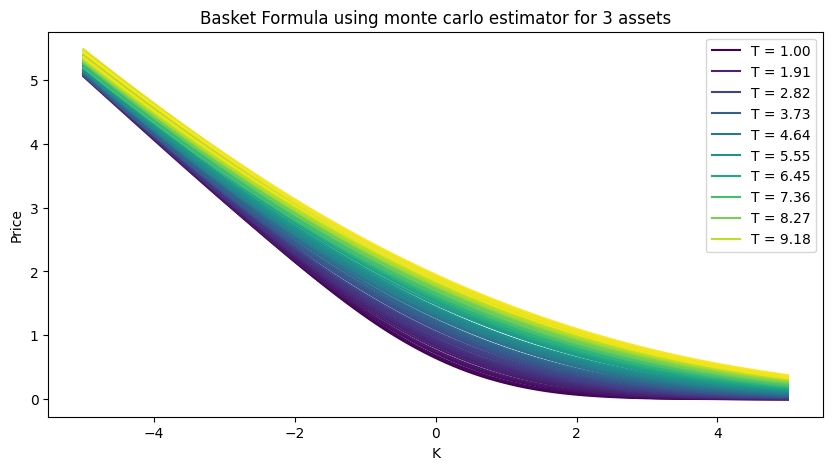

In [105]:
plt.figure(figsize=(10, 5))
colomap = plt.cm.viridis

for k, T in enumerate(tqdm(T_values)):
    prices = monte_carlo_basket(S0s, sigmas, correlation_matrix, T, Ks, 1000, 10000)
    if k % 10 == 0:
        plt.plot(Ks, prices, label='T = %.2f' % T, color=colomap(k / len(T_values)))
    else:
        plt.plot(Ks, prices, color=colomap(k / len(T_values)))

plt.xlabel('K')
plt.ylabel('Price')
plt.legend()
plt.title('Basket Formula using monte carlo estimator for %d assets' % d)
plt.show()

  0%|          | 0/99 [00:00<?, ?it/s]

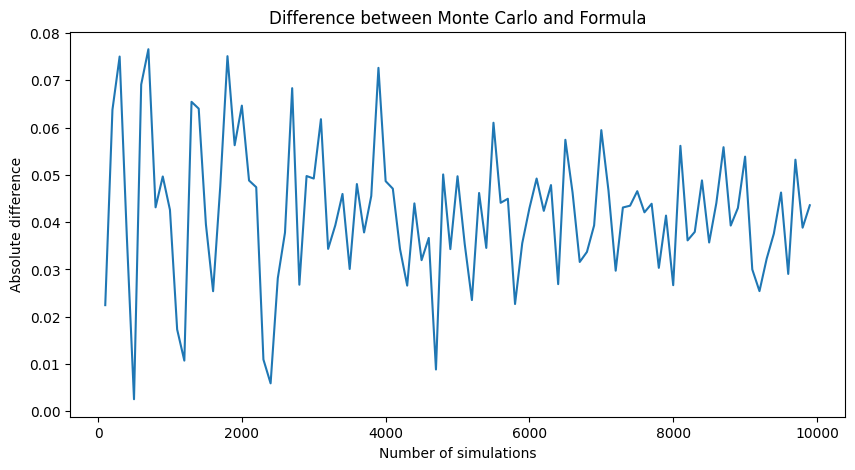

In [104]:
# check diff between monte carlo and formula
K_test = np.array([0])
diff = []

for num_simulations in tqdm(range(100, 10000, 100)):
    prices_formula = basket_formula(S0s.astype(np.float32), sigmas.astype(np.float32), correlation_matrix.astype(np.float32), 1, K_test)
    prices_monte_carlo = monte_carlo_basket(S0s.astype(np.float32), sigmas.astype(np.float32), correlation_matrix.astype(np.float32), 1, K_test, 1000, num_simulations)
    diff.append(np.abs(prices_formula - prices_monte_carlo))

plt.figure(figsize=(10, 5))
plt.plot(range(100, 10000, 100), diff)
plt.xlabel('Number of simulations')
plt.ylabel('Absolute difference')
plt.title('Difference between Monte Carlo and Formula')
plt.show()

